# `Poesidon-viewer` plot hydrographic section demonstration

Extract temperature/salinity section along a specified (longitude, latitude) transect. This process mimics a hydrographic section from in-situ measurements (like a ship CTD section). The locations are easily imported to the notebook from the `Poseidon-viewer`.

This notebook:

* Demonstrates the interface to the `Poseidon-viewer` on SciServer
* Uses the [oceanspy](https://oceanspy.readthedocs.io/en/latest/) `subsample.mooring_array` method to extract model data closest to the specified positions.
* Makes plots showing the location of the specified section and hydrographic properties along it.

Author: Tom Haine, Miguel Jimenez-Urias, Mitya Medvedev: Jul, Dec '23

In [1]:
import oceanspy as ospy
from oceanspy.llc_rearrange import Dims, LLCtransformation
from oceanspy.utils import viewer_to_range

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

print(ospy.__version__)      # Version information

0.3.5.dev18+gc9ba7bc


In [2]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40391,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: 1 minute ago,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:44448,Total threads: 1
Dashboard: http://127.0.0.1:41279/status,Memory: 25.00 GiB
Nanny: tcp://127.0.0.1:40372,


To make a plot showing the geographic and model grid space locations of the specified section, we need to define the `getIndices` conversion function. The function finds the model grid-space indices of the specified (lon, lat) section coordinates.

In [3]:
def getIndices(lons,lats):
    def findIntersection(contour1,contour2):
        # See: https://stackoverflow.com/questions/42838190/finding-intersection-of-two-contour-plots-in-python
        # The code uses the shapely intersection method.
        from shapely import geometry
        p1 = contour1.collections[0].get_paths()[0]
        v1 = p1.vertices
        p2 = contour2.collections[0].get_paths()[0]
        v2 = p2.vertices
        poly1 = geometry.LineString(v1)
        poly2 = geometry.LineString(v2)
        intersection = poly1.intersection(poly2)
        return intersection

    import numpy as np
    Nstations = len(lons)
    lonsind = np.zeros(Nstations)
    latsind = np.zeros(Nstations)
    # How can this contour intersection code be written without actually rendering the plot?
    figtest = plt.figure()
    axtest = figtest.add_subplot( 121 )
    for ll in np.arange(0,Nstations):
        c1 = axtest.contour(cut_od.dataset.X,cut_od.dataset.Y,cut_od.dataset.XC,[lons[ll]],colors='green', linewidths=1)
        c2 = axtest.contour(cut_od.dataset.X,cut_od.dataset.Y,cut_od.dataset.YC,[lats[ll]],colors='blue', linewidths=1)

        intersection_example = findIntersection(c1,c2)
        axtest.scatter(intersection_example.x, intersection_example.y)
        lonsind[ll] = intersection_example.x
        latsind[ll] = intersection_example.y

    # plt.show()
    plt.close()
    return lonsind,latsind

### Pick the model dataset here. 

* `ECCO` is quick, coarse resolution, and good for initial exploration and to test very long sections.
* `LLC4320` is slow, high resolution, and good for final figures.

See the [Poseidon datasets](https://www.poseidon-ocean.net/products/datasets/) for more details.

In [4]:
OGCM_dataset = 'ECCO'
# OGCM_dataset = 'LLC4320'
od = ospy.open_oceandataset.from_catalog(OGCM_dataset)

if OGCM_dataset == 'LLC4320':
    od._ds = od._ds.drop_vars({'k', 'k_u', 'k_p1', 'k_l'})
    co_list = [var for var in od._ds.variables if "time" not in od._ds[var].dims]
    od._ds = od._ds.set_coords(co_list)
elif OGCM_dataset == 'ECCO':
    od._ds = od._ds.drop_vars('time_bnds')
    ds = od.dataset
    ds['Temp'] = ds['THETA']
    ds['S'] = ds['SALT']
    od = ospy.OceanDataset(ds)
    
varList = ['Temp', 'S']        # Specify variables of interest here.
timeFreq= None
Nvars = len(varList)
tmp_S = od._ds['S'].squeeze()
od._ds = od._ds.drop_vars([var for var in od._ds.data_vars if var not in varList]).where(tmp_S > 0.0)  # Drop unneeded variables and mask land.

Opening ECCO.
ECCO v4r4 3D dataset, ocean simulations on LLC90 grid (monthly mean output)


### Select the (longitude, latitude) coordinates of the section required from the Poseidon Viewer

1. Use the Poseidon Viewer app to select the stations you want using the polyline select button:

<div>
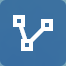
</div>

2. Mark the section with the select button and save it via the save button:

<div>
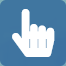
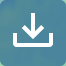
</div>

This method requires that the Poseidon Viewer is running in this SciServer container.

#### Or: 

2. Copy the section from the Poseidon Viewer and paste it in the cell below via the copy to clipboard button:

<div>
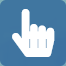
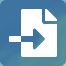
</div>

An example appears in the commented line below. This method works using the Poseidon Viewer app in the SciServer container, or in the standalone version.

The `oceanspy` `viewer_to_range()` function converts the JSON object from the Poseidon-viewer to a `list` that's ready for `oceanspy`.

In [5]:
from poseidon_viewer import get_shapes
import json, jmespath
# shapes = json.loads(get_shapes())

# p1 = jmespath.search('features[?geometry.type==\'LineString\'].{type:geometry.type, coordinates:geometry.coordinates,timeFrom:properties.timeFrom,timeTo:properties.timeTo}', shapes)
# this_time = p1[0]['timeFrom'][:-1]
# lons, lats = viewer_to_range(p1)

In [6]:
# This example section is down the Atlantic Ocean near the Prime Meridian. 
p1 = [{"type":"LineString","coordinates":[[-19.700100751971487,63.32593798716556],[-19.10043369595873,36.26328779706721],[-33.21881436814727,21.362033989529394],[-32.7332518690686,3.1304859432498233],[-19.879477429244886,-15.695821553654838],[-18.967074981423043,-70.85248582475455],[-12.504832577650182,-71.67697416180943]]}]
# This example section is close to 26N in the Atlantic.
# p1 = [{"type":"LineString","coordinates":[[-80.5182040062176,28.169499839032866],[-78.45990080523065,28.28650021318471],[-72.16527272963661,23.537599300368043],[-17.90861520259337,23.664900805164223],[-16.292948886487597,22.933118707879217]]}]
# This example section crosses the Brazil current.
# 22Jul23: It takes a LONG time!
# p1 = [{"type":"LineString","coordinates":[[-53.08024052253604,-33.835071916852705],[-50.94118455943738,-35.084343017381656],[-47.317139452651155,-36.15891840575311],[-41.84599030150932,-36.64304362157784]]}]
# This example section runs from Tasmania to Antarctica.
# p1 = [{"type":"LineString","coordinates":[[146.49200584568257,-43.77914745605575],[146.23031671037378,-46.613171496049034],[144.75136842195846,-52.168233293445496],[141.57400531406276,-60.52575854668494],[138.44175115933828,-66.46650376712732]]}]

this_time = '2012-04-25T00'
lons, lats = viewer_to_range(p1)

extracting LineString


### Create dataset with section data for the time of interest using `cutout`.

In [7]:
cutout_kwargs = {
    'varList': varList,
    'timeRange': this_time,
    'XRange': lons, 
    'YRange': lats, 
    'add_Hbdr': True,
}

# Cutout region of interest to make background plot of depth:
cut_od = od.subsample.cutout(**cutout_kwargs)

Cutting out the oceandataset.
faces in the cutout [0, 1, 2, 6, 10, 11, 12]


### Next compute the `mooring_array`

The oceanspy `subsample.mooring_array` method extracts the model data nearest to the specified space coordinates along the section.
Then `sel(...,method = 'nearest')` selects the timestep nearest to the specified time.

In [8]:
od_moor = cut_od.subsample.mooring_array(Xmoor=lons, Ymoor=lats)
od_moor._ds = od_moor._ds.sel(time = this_time,method = 'nearest')

Cutting out the oceandataset.
Extracting mooring array.


### Plot the section location as a sanity check.

Two versions of the plot are shown: Geographic coordinates (left) and grid cell coordinates (right). The specified section is in blue, and the nearest model grid cells are in red. 

Sometimes the geographic coordinates plot fails, especially if face 6 (Arctic) is involved. We trap that error.

The cutout dataset has NaNs in its (XC,YC) coordinates, which causes the horizontal_section plot to fail. Usually, this occurs because face 6 (Arctic) is involved in the cutout. To avoid the error, reduce the size of the cutout. Otherwise, rely on grid point coordinates to visualize the section.


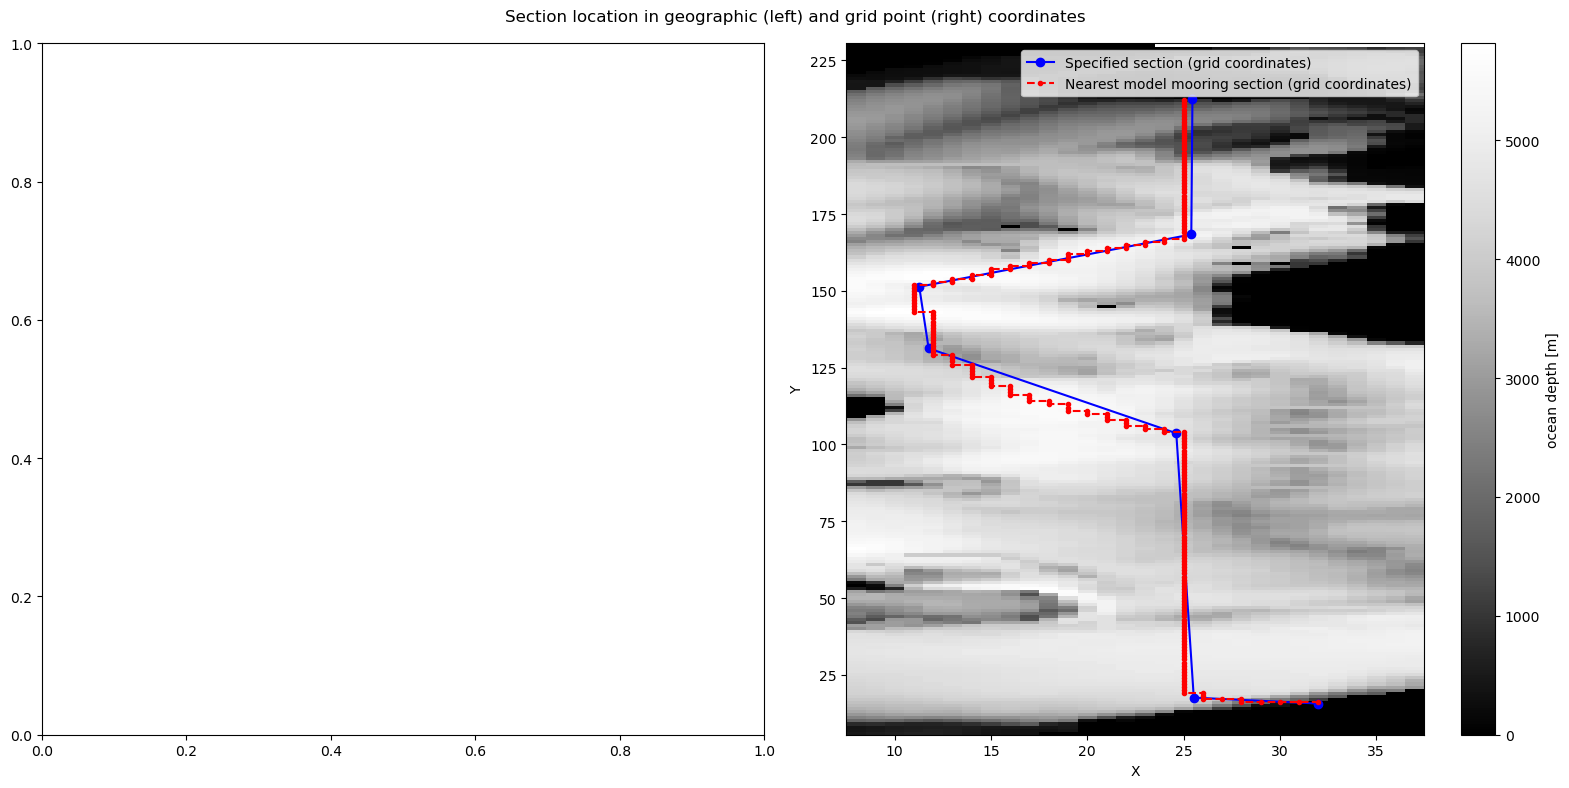

In [9]:
# Cutout region of interest to make background plot of depth:
# cut_od = od.subsample.cutout(XRange = lons,YRange = lats, add_Hbdr=True)

# Get coordinates of mooring array in geographic and index space:
Xmoor = od_moor.dataset['XC'].squeeze().values
Ymoor = od_moor.dataset['YC'].squeeze().values
Xind = od_moor.dataset['Xind'].squeeze().values
Yind = od_moor.dataset['Yind'].squeeze().values

# Get index coordinates of specified section:
[lonsind,latsind] = getIndices(lons,lats)

# Make plots.
plt.rcParams["figure.figsize"] = [16,8]      # Adjust the plot aspect ratio here.
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Section location in geographic (left) and grid point (right) coordinates')

# Left hand plot in geographic space (use_coords=True). Sometimes this errors, so trap that.
try:
    cut_od.plot.horizontal_section(ax=ax1,varName="Depth", cmap='Greys_r', use_coords=True)
    ax1.plot(lons, lats, 'bo-', label='Specified section (geographic coordinates)')
    ax1.plot(Xmoor, Ymoor, "r.", ls='--', label='Nearest model section (geographic coordinates)')
    ax1.legend()

except ValueError:
    print("The cutout dataset has NaNs in its (XC,YC) coordinates, which causes the horizontal_section plot to fail. Usually, this occurs because face 6 (Arctic) is involved in the cutout. To avoid the error, reduce the size of the cutout. Otherwise, rely on grid point coordinates to visualize the section.")

# Right hand plot in index space (use_coords=False).
cut_od.plot.horizontal_section(ax=ax2,varName="Depth", cmap='Greys_r', use_coords=False)
ax2.pcolormesh(cut_od.dataset.X,cut_od.dataset.Y,cut_od.dataset.Depth,cmap='Greys_r')
ax2.plot(lonsind, latsind, 'bo-', label='Specified section (grid coordinates)')
ax2.plot(Xind, Yind, "r.", ls='--', label='Nearest model mooring section (grid coordinates)')
ax2.legend();

Notice that the `mooring_array` connects the section locations with a great circle. To avoid this behavior, add more points along the path you want.

### Plot hydrographic data along section:

Computing potential density anomaly using the following parameters: {'eq_state': 'jmd95'}.
Computing potential density anomaly using the following parameters: {'eq_state': 'jmd95'}.


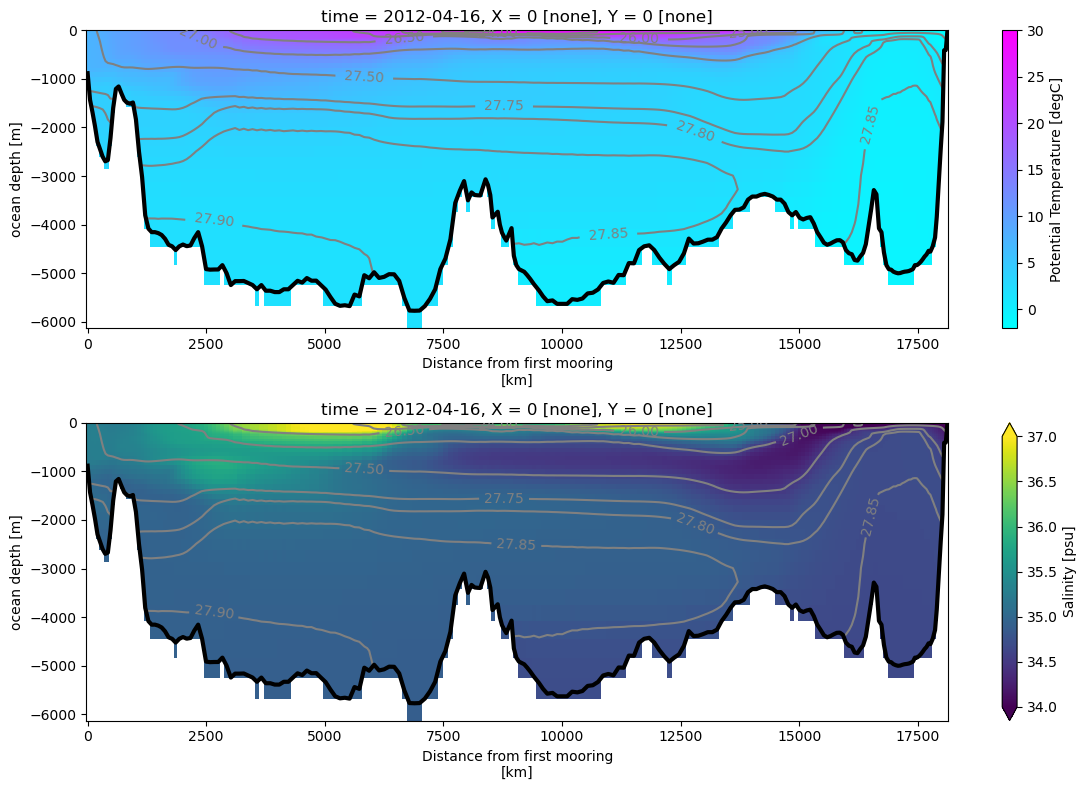

In [10]:
plt.rcParams["figure.figsize"] = [12.0,8.0]
sigma_levels = [20.0,21.0,22.0,23.0,24.0,25.0,26.0,26.5,27.0,27.5,27.75,27.8,27.85,27.9,28.0,28.5,29.0]
ax1 = plt.subplot(2,1,1)
od_moor.plot.vertical_section(
    ax = ax1,
    plotType = 'pcolormesh',
    varName="Temp",
    vmin = -2.0,
    vmax = 30.0,
    contourName="Sigma0",
    contour_kwargs = {'levels' : sigma_levels},
    robust=True,
    cmap="cool",
)
(-od_moor._ds['Depth'].squeeze()).plot(x='mooring_dist', color='k', lw=3)

ax2 = plt.subplot(2,1,2)
od_moor.plot.vertical_section(
    ax = ax2,
    plotType = 'pcolormesh',
    varName="S",
    vmin = 34.0,
    vmax = 37.0,
    contourName="Sigma0",
    contour_kwargs = {'levels' : sigma_levels},
    robust=True,
)
(-od_moor._ds['Depth'].squeeze()).plot(x='mooring_dist', color='k', lw=3)

plt.show()

### Plot TS diagram along section:

Isopycnals: Computing potential density anomaly using the following parameters: {'eq_state': 'jmd95'}.


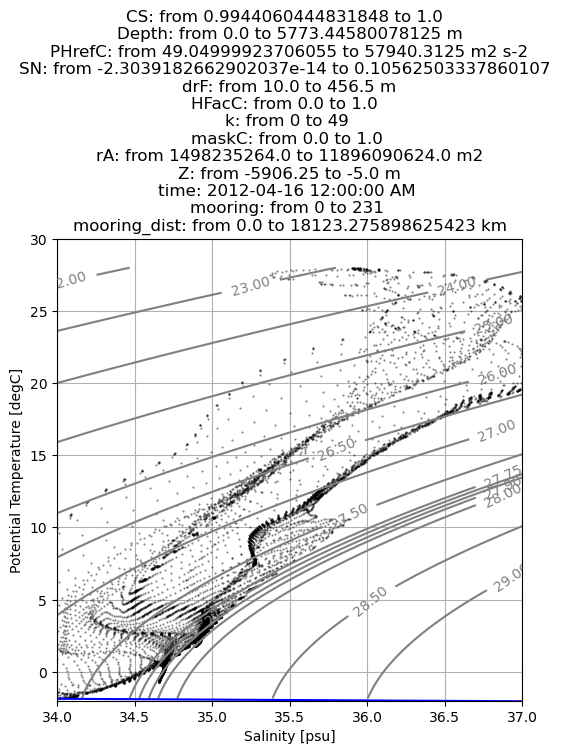

In [11]:
plt.rcParams["figure.figsize"] = [6,6]
axTS = od_moor.plot.TS_diagram(markersize=1, alpha=0.5, contour_kwargs = {'levels' : sigma_levels})
axTS.set_xlim(34,37)
axTS.set_ylim(-2,30)
axTS.grid()

For more information about what to do next to analyze these data, see the [OceanSpy Kogur tutorial](https://oceanspy.readthedocs.io/en/latest/Kogur.html).